In [38]:
import tensorflow as tf
from tensorflow import keras
from keras.regularizers import l2
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Cropping2D
from keras.models import Model
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import rasterio
import cv2
import os
import random
import segmentation_models as sm
%matplotlib inline

Segmentation Models: using `keras` framework.


In [153]:
src = '../data_256/'

def get_nice_images(data_path):

    images_path = data_path + 'images/'
    labels_path = data_path + 'labels/'

    imgs = []
    lbls = []

    for im_name in os.listdir(images_path):
        lbl_name = im_name + 'f'
        img = (rasterio.open(images_path + im_name))
        lbl = (rasterio.open(labels_path + lbl_name))

        img = np.array([(img.read(1))/255, (img.read(2))/255, (img.read(3))/255], dtype=np.float32)
        lbl = np.array((lbl.read(1) > 0.5).astype(np.float32))

        if (lbl.sum()/lbl.size > 0.01) and (lbl.sum()/lbl.size < 0.5) and (img==0).sum() < 0.3:
            print('Found!!')
            imgs.append(img)
            lbls.append(lbl)

    return np.array(imgs), np.array(lbls)

In [154]:
X_input, y_input = get_nice_images(src)

c:\Users\Елена\AppData\Local\Programs\Python\Python310\lib\site-packages\rasterio\__init__.py:321: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Found!!
Found!!
Found!!
Found!!
Found!!
Found!!
Found!!
Found!!
Found!!
Found!!
Found!!
Found!!
Found!!
Found!!
Found!!
Found!!
Found!!
Found!!
Found!!
Found!!
Found!!
Found!!
Found!!
Found!!
Found!!
Found!!
Found!!
Found!!


In [155]:
X_input.shape

(28, 3, 256, 256)

In [156]:
X_example = X_input.transpose(0,2,3,1)

In [119]:
class DataLoader:

    def __init__(self, path_to_images = 'data/images/', path_to_labels = 'data/labels/'):
        # Initializing paths
        self.path_to_images = path_to_images
        self.path_to_labels = path_to_labels

    # Data import
    def im_import(self, path_to_images, path_to_labels, train=True):
        X, y = get_nice_images(src)
        return X, y
    
    def random_flip(self, image, label):
        # Randomly flip the image horizontally or vertically
        flip_dir = np.random.choice([-1, 0, 1])
        if flip_dir == -1:
            return cv2.flip(image, 0), cv2.flip(label, 0)
        elif flip_dir == 1:
            return cv2.flip(image, 1), cv2.flip(label, 1)
        return image, label

    def random_rotation(self, image, label):
        # Randomly rotate the image by a random angle
        rows, cols = image.shape[:2]
        rotation_angle = np.random.uniform(-100, 100)
        rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), rotation_angle, 1)
        return cv2.warpAffine(image, rotation_matrix, (cols, rows)), cv2.warpAffine(label, rotation_matrix, (cols, rows))


    def random_contrast(self, image):
        # Randomly change the contrast of the image using keras (no changing for labels since the location of roofs is not changing)
        contrast = keras.layers.experimental.preprocessing.RandomContrast(0.4)
        return contrast(image)

    def data_augmentation(self, image, label):
        # Applying flipping, rotation and contrast to the given image and label
        image_new, lbl_new = self.random_flip(image, label)
        image_new, lbl_new = self.random_rotation(image_new, lbl_new)
        image_new = self.random_contrast(image_new)
        return image_new, lbl_new
    
    def edge_detection(self, data):
        # Detecting edges on the input data and stacking it with the original image
        X_edges = []
        for img in data:
            gray = np.mean(img, axis=2) #converting to grayscale
            edges = cv2.Canny(np.uint8(gray*255), 150, 250) #getting edges using Canny edge detection
            overlay = cv2.addWeighted(img, 1, np.dstack((edges/255, edges/255, edges/255)), 0.7, 0) #overlaying edges with the original image
            X_edges.append(overlay)
        return np.array(X_edges)
    
    def load_data(self, X, y):
        # Data loader
        #X, y = self.im_import(self.path_to_images, self.path_to_labels) #importing data
        im_num = len(X) #number of images
        X_aug = np.array([]) #this can be accelerated by pre-defining the size of the array
        y_aug = np.array([]) #to change later
        for i in range(im_num):
            # Obtaining 5 new images for one original image via data augmentation
            for j in range(5): 
                im, lbl = self.data_augmentation(X[i], y[i])
                # If we get an image that is different from the original, appending to the new dataset
                if not np.array_equal(im, X[i]):
                    X_aug = np.append(X_aug, im)
                    y_aug= np.append(y_aug, lbl)
                else: 
                    # Repeating the previous step
                    j = j - 1

        X_aug = np.reshape(X_aug, (im_num*5, 256, 256, 3))
        y_aug = np.reshape(y_aug, (im_num*5, 256, 256))

        X = np.reshape((np.append(X, X_aug)), (len(X) * 6, 256, 256, 3))
        y = np.reshape((np.append(y, y_aug)), (len(y) * 6, 256, 256))

        # Getting edges
        # X_edges = self.edge_detection(X)

        # Since np.unique(y) = {0,1,2,...,256}, mapping it to {0.1}
        return X, (y > 0).astype(float)

    

In [157]:
dat_loader = DataLoader()
X, y = dat_loader.load_data(X_example, y_input)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


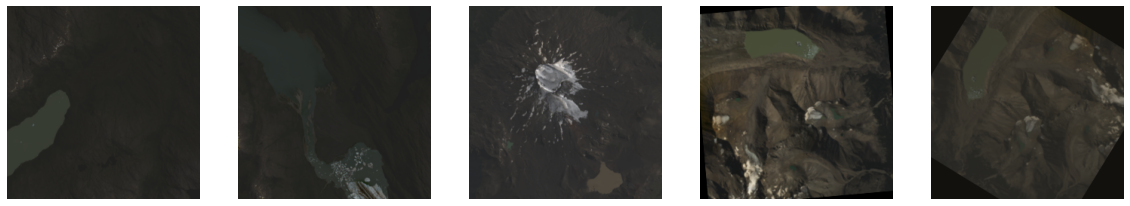

In [168]:
plt.figure(figsize=(20, 5))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(X[i+25])
    plt.axis("off")

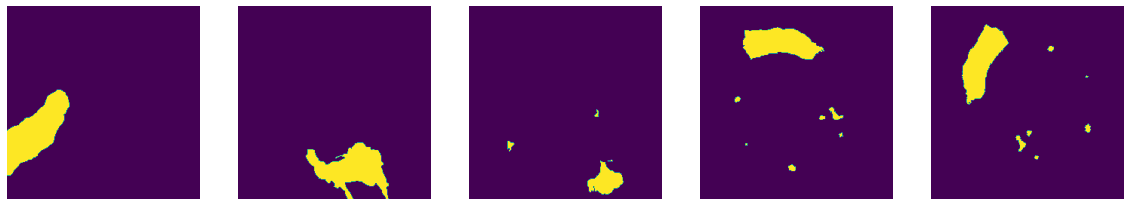

In [169]:
plt.figure(figsize=(20, 5))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(y[i+25])
    plt.axis("off")

In [170]:
# U-Net architecture from Ronneberger, O., Fischer, P., Brox, T. (2015). 
# U-Net: Convolutional Networks for Biomedical Image Segmentation. 
# In: Navab, N., Hornegger, J., Wells, W., Frangi, A. 
# (eds) Medical Image Computing and Computer-Assisted Intervention – 
# MICCAI 2015. MICCAI 2015. Lecture Notes in Computer Science(), 
# vol 9351. Springer, Cham. https://doi.org/10.1007/978-3-319-24574-4_28

def unet(input_size=(256, 256, 3)):
    inputs = keras.layers.Input(input_size)

    # Contracting path

    c1 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(0.01))(inputs)
    c1 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(0.01))(c1)
    p1 = keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(0.01))(p1)
    c2 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(0.01))(c2)
    p2 = keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(0.01))(p2)
    c3 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(0.01))(c3)

    # Expansive path

    u4 = keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = keras.layers.concatenate([u4, c2])
    c4 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(0.01))(u4)
    c4 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(0.01))(c4)

    u5 = keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = keras.layers.concatenate([u5, c1])
    c5 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(0.01))(u5)
    c5 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(0.01))(c5)

    outputs = keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = keras.models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [171]:
# Optimizer Adam with learning rate 0.0001
optim = keras.optimizers.Adam(0.0001)
# ModelCheckpoint for saving weights of the best model
cb = [keras.callbacks.ModelCheckpoint('./best_unet.h5', save_weights_only=True, save_best_only=True, mode='min'),]

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# Dice loss and focal loss are good when we have class imbalance 
dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.BinaryFocalLoss() 
total_loss = dice_loss + (1 * focal_loss)

# Metrics: intersection over union (IOU), F1 score
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [172]:
keras.utils.set_random_seed(42)
un = unet()
un.compile(optimizer=optim, 
            loss=total_loss, 
            metrics=[sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)],)
un.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 12  3584        ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 12  147584      ['conv2d[0][0]']                 
                                8)                                                            

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [174]:
# Fit model
history = un.fit(
   x=X_train,
   y=y_train,
   batch_size=1,
   epochs=7,
   callbacks=cb,
   validation_split=0.2,
   shuffle=True,
)

Epoch 1/7
107/107 [==============================] - 538s 5s/step - loss: 39.6024 - iou_score: 0.2529 - f1-score: 0.2932 - val_loss: 29.3353 - val_iou_score: 0.5081 - val_f1-score: 0.5546
Epoch 2/7
107/107 [==============================] - 583s 5s/step - loss: 23.3688 - iou_score: 0.4431 - f1-score: 0.4905 - val_loss: 18.2532 - val_iou_score: 0.5208 - val_f1-score: 0.5707
Epoch 3/7
107/107 [==============================] - 541s 5s/step - loss: 14.9325 - iou_score: 0.5785 - f1-score: 0.6424 - val_loss: 12.1240 - val_iou_score: 0.6292 - val_f1-score: 0.6904
Epoch 4/7
107/107 [==============================] - 627s 6s/step - loss: 10.2839 - iou_score: 0.5955 - f1-score: 0.6587 - val_loss: 8.6936 - val_iou_score: 0.5663 - val_f1-score: 0.6337
Epoch 5/7
107/107 [==============================] - 673s 6s/step - loss: 7.5655 - iou_score: 0.6416 - f1-score: 0.7039 - val_loss: 6.6758 - val_iou_score: 0.6284 - val_f1-score: 0.6871
Epoch 6/7
107/107 [==============================] - 661s 6s/st

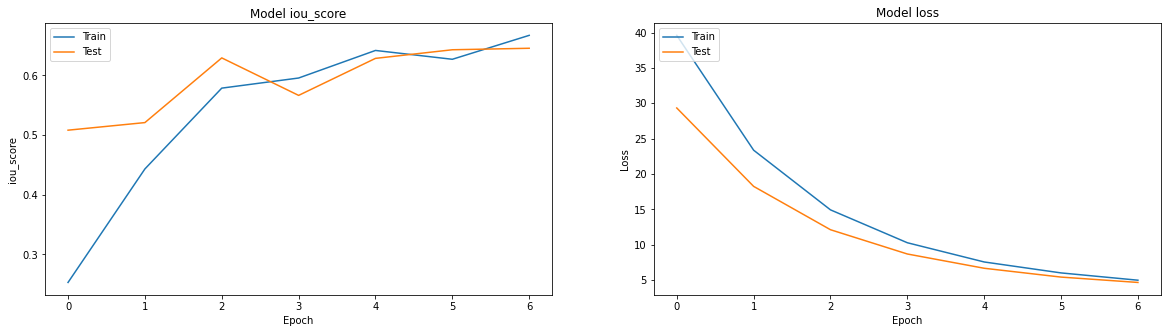

In [175]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [176]:
y_pred = un.predict(X_test)

In [177]:
y_pred.shape

(34, 256, 256, 1)

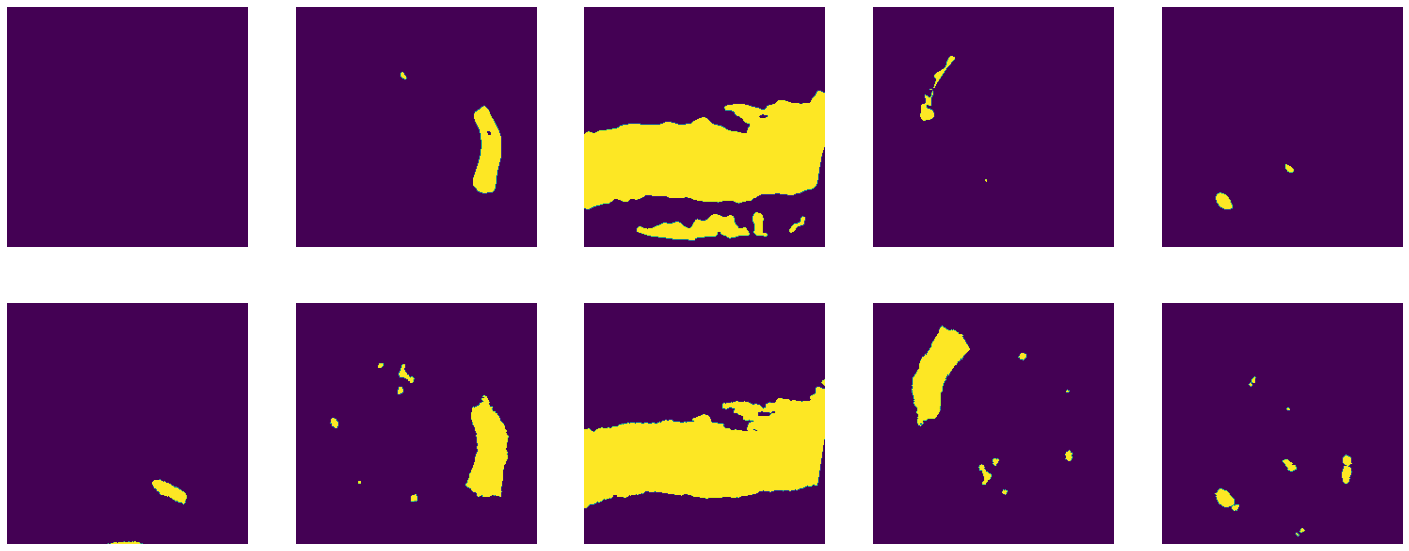

In [180]:
plt.figure(figsize=(25, 10))
for i in range(5):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow((y_pred[i] > 0.5).astype(float))
    plt.axis("off")
    ax = plt.subplot(2, 5, i + 6)
    plt.imshow(y_test[i])
    plt.axis("off")